In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import datetime

import time
from tqdm.auto import tqdm

import requests
import glob
import os
import shutil

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.linear_model import LinearRegression
from sklearn import metrics 


plt.style.use('ggplot')

# Import data

In [2]:
df = pd.read_csv('Energy_production_weather.csv')

In [3]:
df['Wind_tot'] = df['Wind offshore']+df['Wind onshore']
df['Coal_tot'] = df['Fossil brown coal / lignite'] + df['Fossil hard coal']
df['Gas_tot'] = df['Fossil gas'] + df['Fossil coal-derived gas']
df['Hydro pumped storage consumption']  = -df['Hydro pumped storage consumption']
df['Hydro_tot'] = df['Hydro pumped storage consumption'] + df['Hydro Run-of-River']

types = ['Hydro pumped storage consumption', 'Hydro Run-of-River', 'Biomass', 'Geothermal', 
       'Nuclear', 'Coal_tot', 'Fossil oil', 'Gas_tot', 'Others', 'Waste',
       'Wind_tot', 'Solar']



types_rewenables = ['Wind_tot', 'Solar', 'Biomass', 'Hydro Run-of-River', 'Geothermal']
types_fossil = ['Coal_tot', 'Gas_tot', 'Fossil oil']
types_nuclear = ['Nuclear']
types_others = ['Hydro pumped storage consumption', 'Others', 'Waste']

types = types_rewenables+types_fossil+types_nuclear+types_others



# Explore energy data

## First, we have a look at the different production types

Added to "other" category: Geothermal
Added to "other" category: Fossil oil
Added to "other" category: Hydro pumped storage consumption


<IPython.core.display.Javascript object>


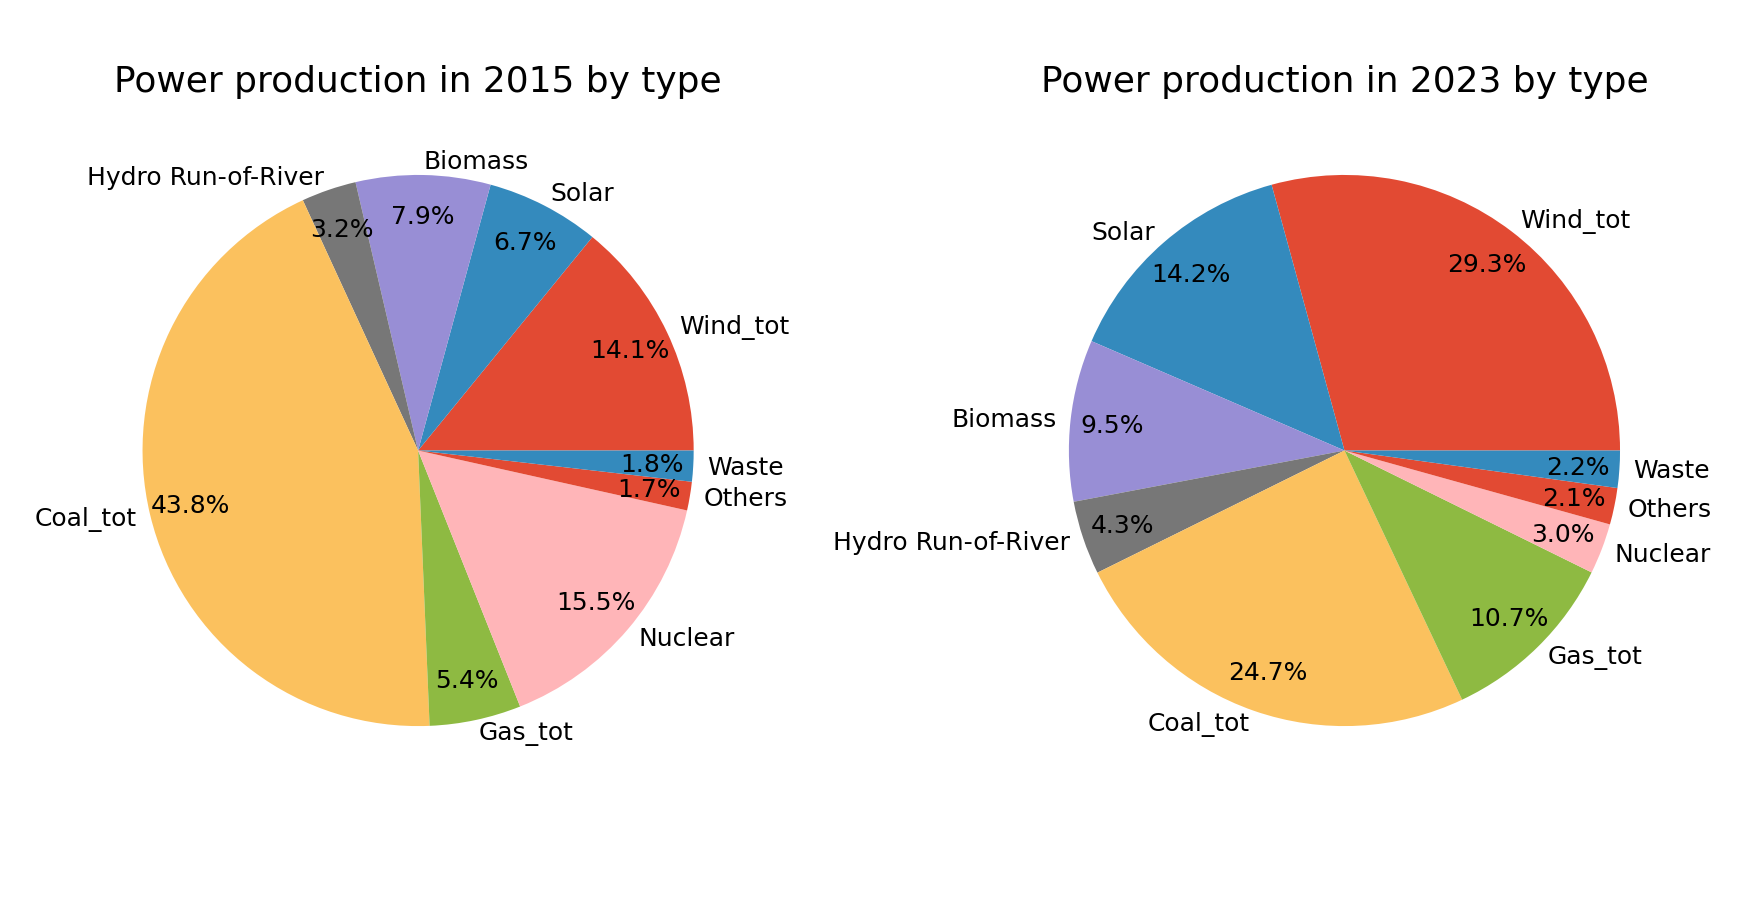

In [24]:
# Combine sources that have less than 2% contribution (in 2023) to 'Others' type
df_combined = df.groupby('year')[types].mean()
for key in types:
    if (df_combined.loc[2023][key]/df_combined.loc[2023].sum()<0.02) & (key!='Others'):
        print('Added to "other" category:', key)
        df_combined['Others'] += df_combined[key]
        df_combined = df_combined.drop(key, axis='columns')
      

fig, axs = plt.subplots(1,2, figsize=(9.7,5))
for i, year_to_plot in enumerate([2015, 2023]):
    df_tt = df_combined.loc[year_to_plot]#.sort_values()
    ax = axs[i]
    ax.pie(df_tt.values,
            labels=df_tt.index, labeldistance=1.05,
            autopct='%1.1f%%', pctdistance=0.85);

    ax.set_title(f'Power production in {year_to_plot} by type')
plt.tight_layout()

plt.savefig('power_type_2015_vs_2023.png')

INSIGHTS:

2023:
- Wind and coal are the two primary power sources, accounting for 53 % of the total power production
- Solar, gas and Biomass account for another 34 %
- Nuclear is almost at zero after shutdown in 2023

Change between 2015-2023:
- Huge reduction of coal (almost halved)
- Wind, solar and gas each roughly doubled since 2015


<IPython.core.display.Javascript object>


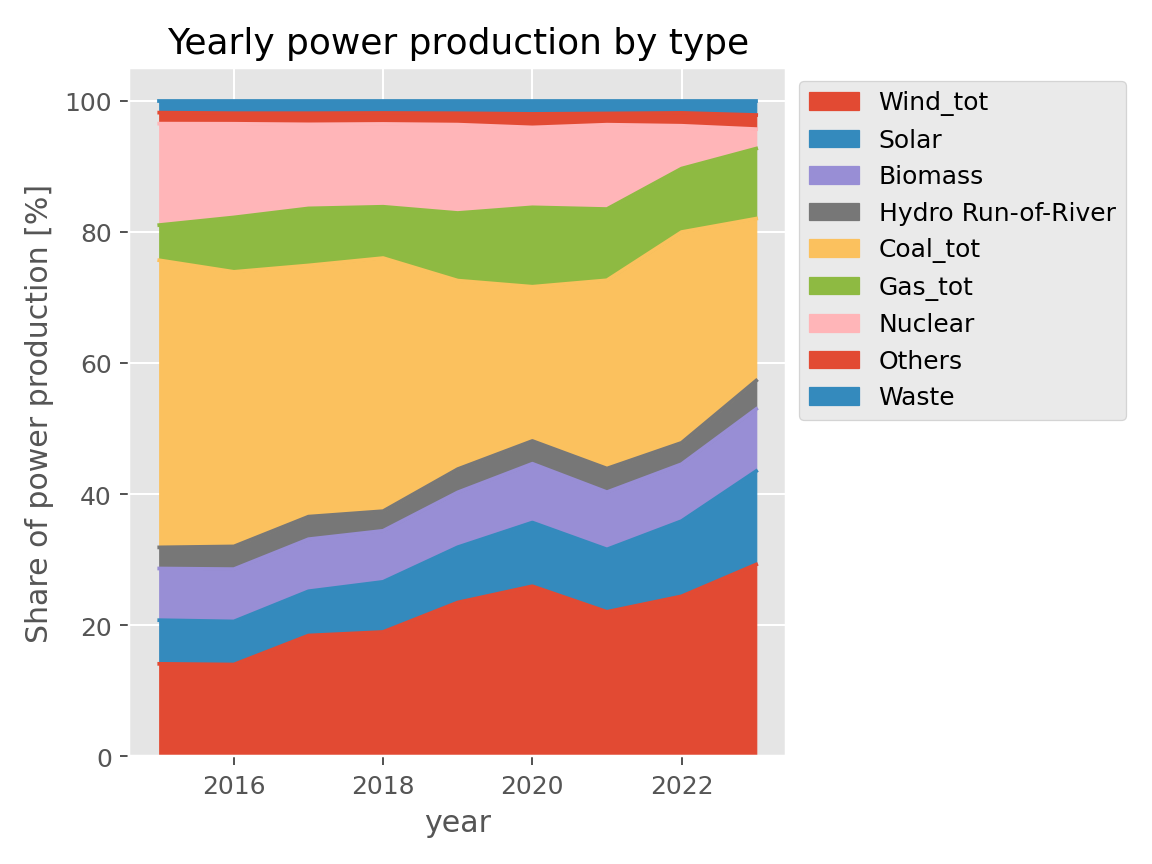

<IPython.core.display.Javascript object>


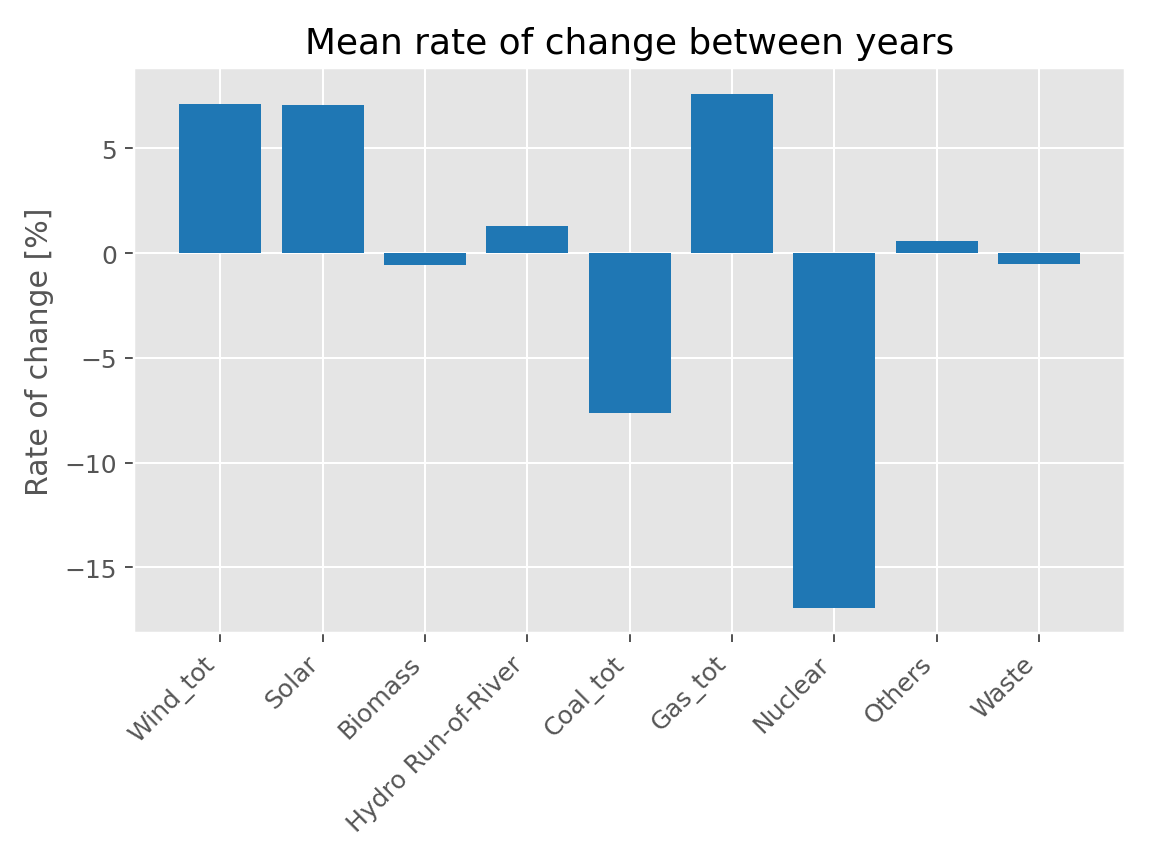

In [27]:
# Normalize each row, convert to %
df_combined.div(0.01*df_combined.sum(axis=1), axis=0).plot.area()
plt.legend(bbox_to_anchor=(1,1,))
plt.ylabel('Share of power production [%]')
plt.title('Yearly power production by type')
plt.tight_layout()
plt.savefig('power_type_over_time.png')

df_t = 100*df_combined.pct_change().iloc[1:].mean(axis='rows')
plt.figure()
plt.bar(df_t.index, df_t.values, color='tab:blue')
plt.xticks(rotation=45, ha='right')
plt.title('Mean rate of change between years')
plt.ylabel('Rate of change [%]')
plt.tight_layout()
plt.savefig('power_type_rate_of_change.png')


INSIGHTS: 
- Substantial increase: Wind, solar and gas
- Substantial decrease: Coal and Nuclear

<IPython.core.display.Javascript object>


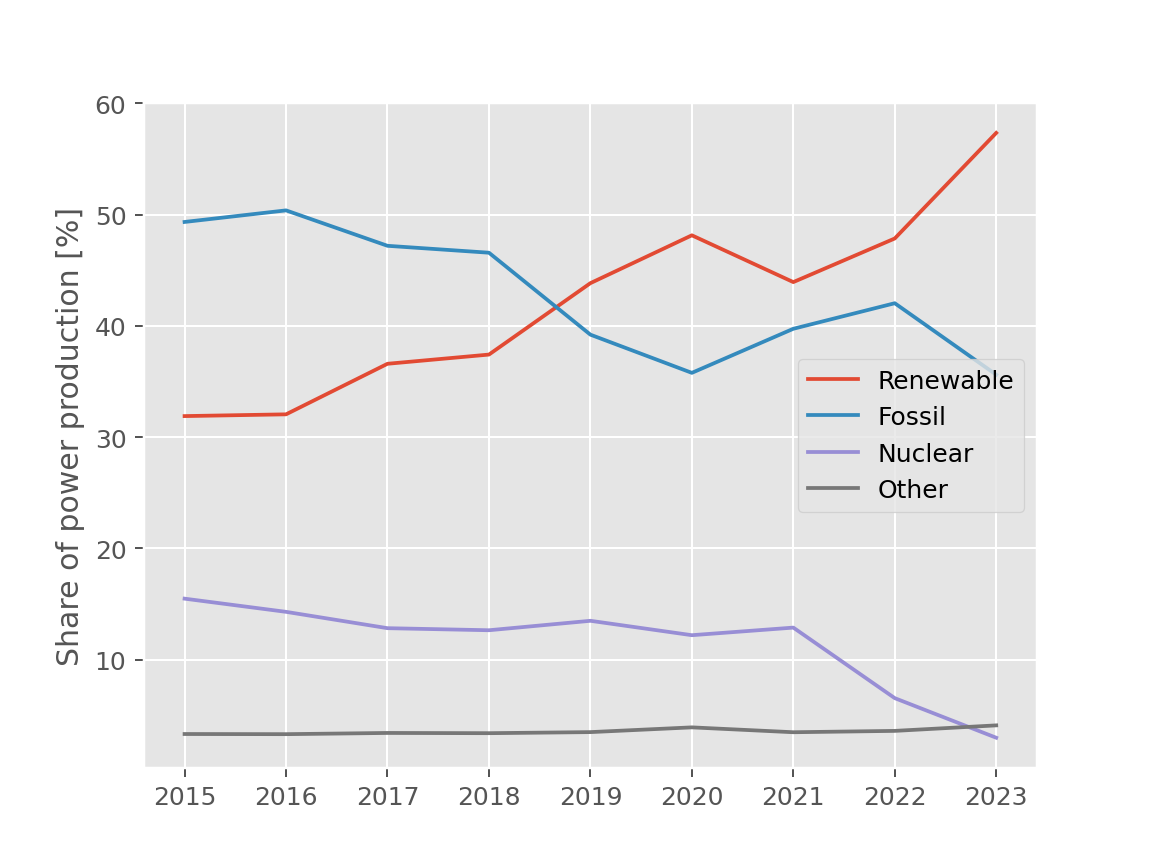

Change of Renewable from 2015-2023 [%]: 79.84
Change of Fossil from 2015-2023 [%]: -27.83
Change of Nuclear from 2015-2023 [%]: -80.8
Change of Other from 2015-2023 [%]: 23.519999999999996


In [28]:
df_t = df.groupby('year')[types].mean()
df_t = df_t.div(0.01*df_t.sum(axis=1), axis=0) # Normalize each row, convert to %

labels = ['Renewable', 'Fossil', 'Nuclear', 'Other']
plt.figure()
for i, key in enumerate([types_rewenables, types_fossil, types_nuclear, types_others]):
    plt.plot(df_t[key].sum(axis=1), label=labels[i])
    print(f'Change of {labels[i]} from 2015-2023 [%]:', round(100*df_t[key].sum(axis=1).iloc[-1]/df_t[key].sum(axis=1).iloc[0], 2)- 100)
plt.legend(loc='best')
plt.ylabel('Share of power production [%]')
plt.savefig('renewable_share_over_time.png')



INSIGHTS: 
- Renewables grew by 80% from 2015-2023
- Fossils decreased by 38 %
- Nuclear features quick drop after 2012

<IPython.core.display.Javascript object>


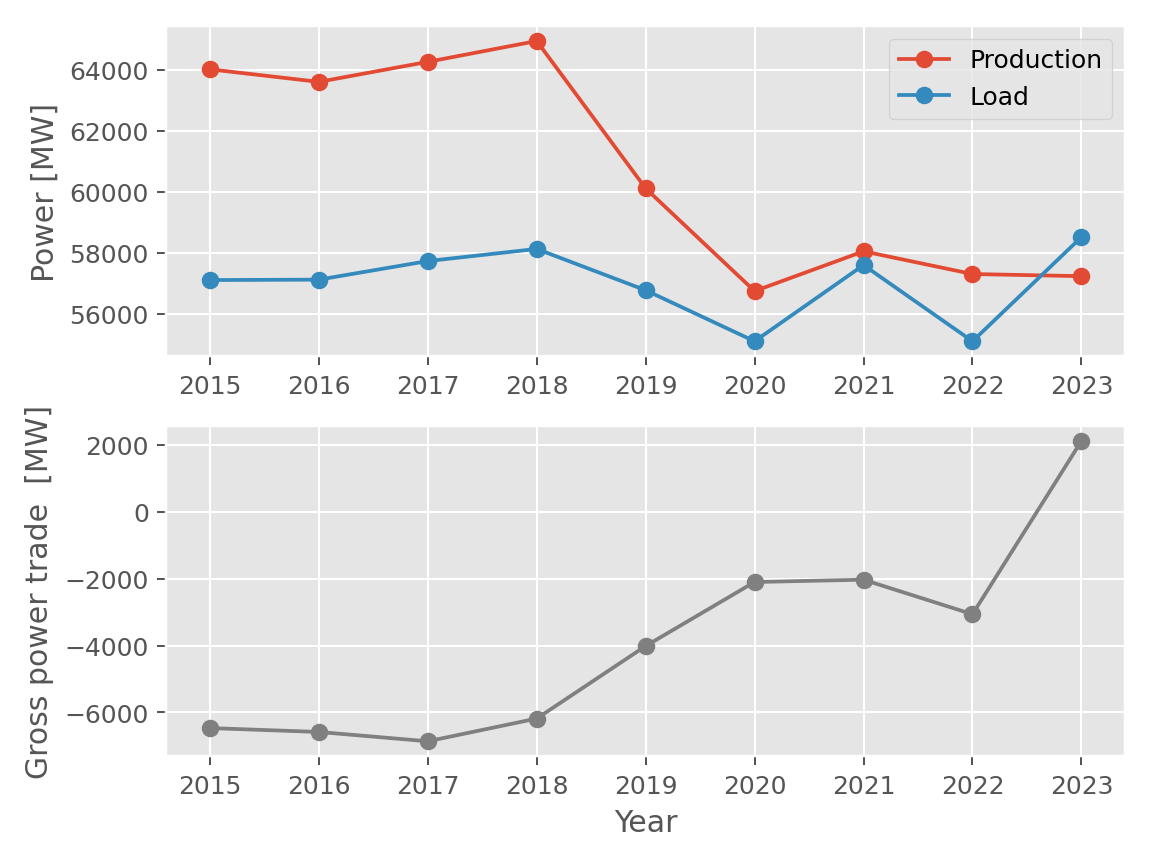

In [29]:
df_t = df.groupby('year')[types+['Load', 'Cross border electricity trading']].mean()
# Correction factors for partial data
correction = 365*24/df.groupby('year').size()

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(correction*df_t[types].sum(axis=1), 'o-', label='Production')
ax1.plot(correction*df_t['Load'], 'o-', label='Load')
ax1.legend()
ax1.set_ylabel('Power [MW]')

ax2.plot(correction*df_t['Cross border electricity trading'], 'o-', label='Gross trade', color='gray')
ax2.set_xlabel('Year')
ax2.set_ylabel('Gross power trade  [MW]')
#plt.ylim([0, None])
plt.tight_layout()

plt.savefig('production_vs_trade_over_time.png')


## Now we look at temporal variations

<IPython.core.display.Javascript object>


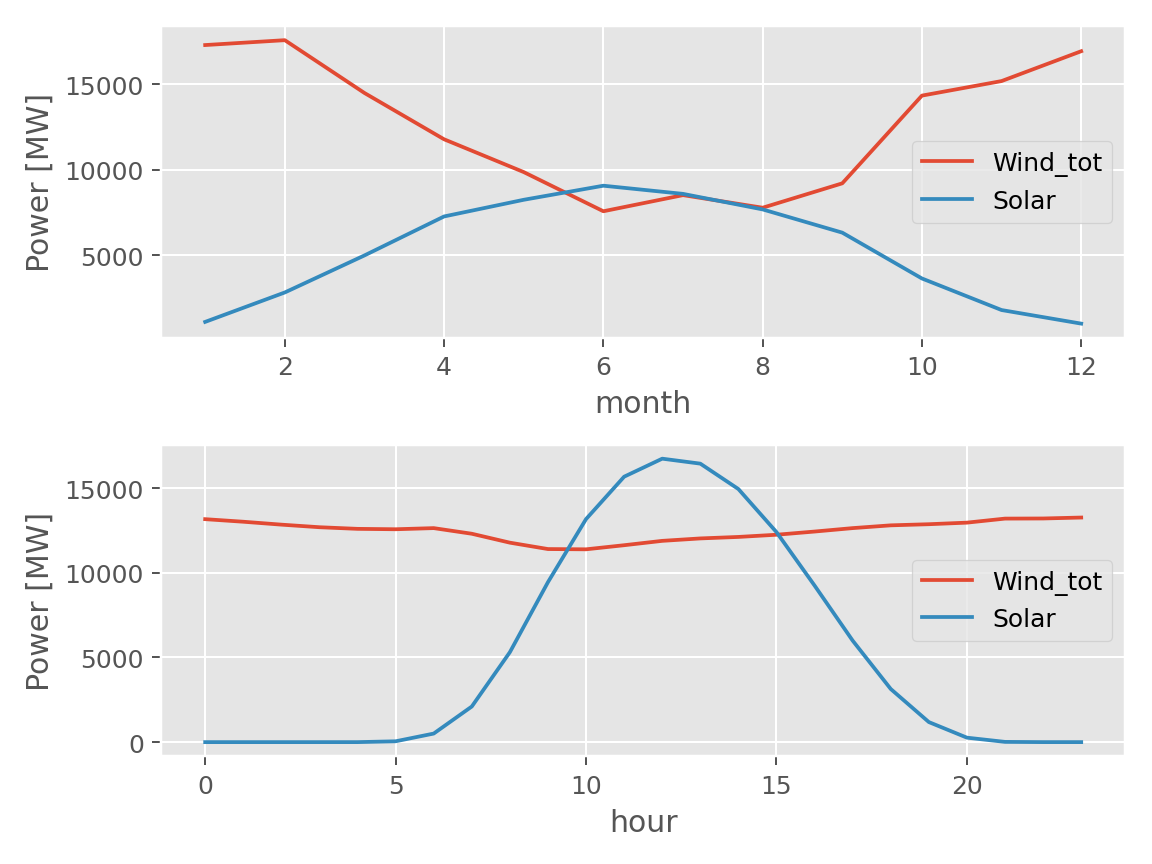

In [30]:
fig, axs = plt.subplots(2,1)
for i, time_scale in enumerate(['month', 'hour']):
    ax = axs[i]
    for key in ['Wind_tot', 'Solar']:
        ax.plot(df.groupby(time_scale)[key].mean(), label=key)

    ax.legend()
    ax.set_xlabel(time_scale)
    ax.set_ylabel('Power [MW]')
    
plt.tight_layout()

plt.savefig('temporal_variation_renewables.png')


INSIGHTS: 
- Wind and solar feature anticyclical yearly variation: Solar peaks in summer, wind peaks in winter
- Wind features - on average - only slight (about 10%) variation during the day
- Solar obviously features huge variation during the day

<IPython.core.display.Javascript object>


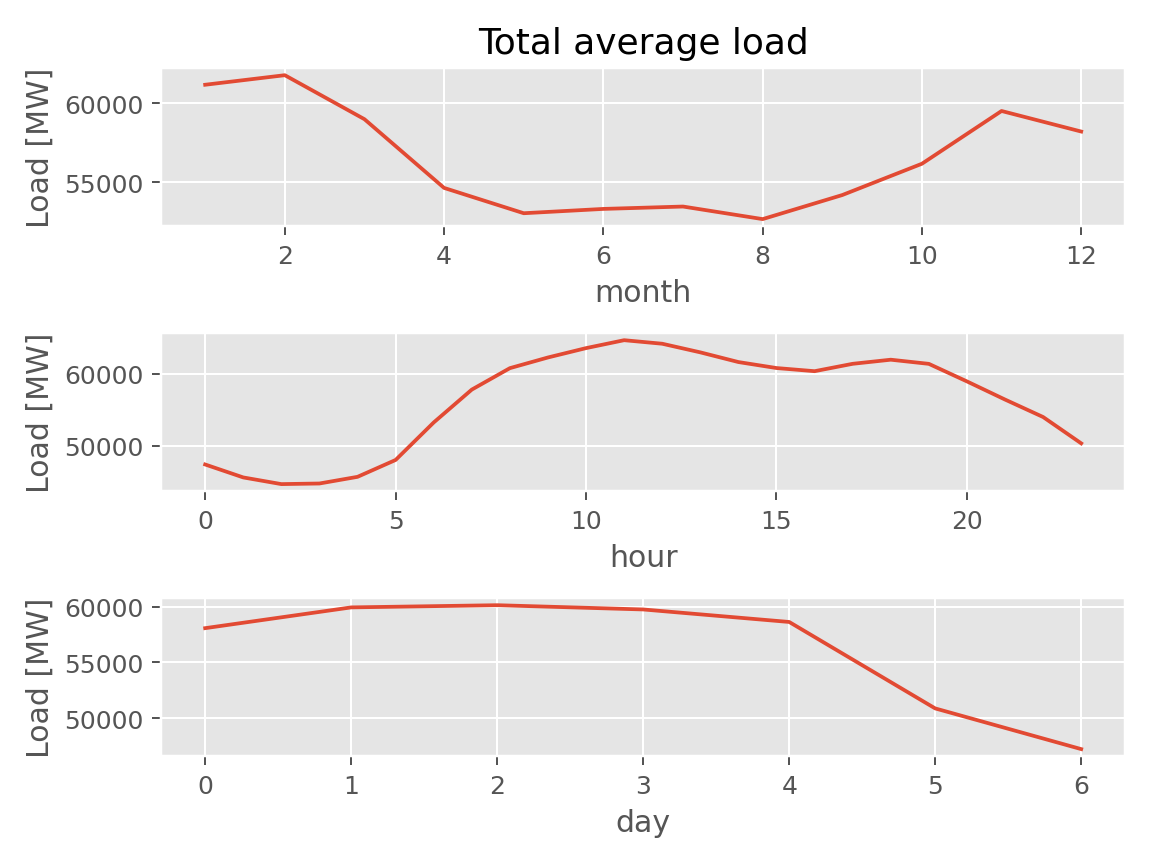

<IPython.core.display.Javascript object>


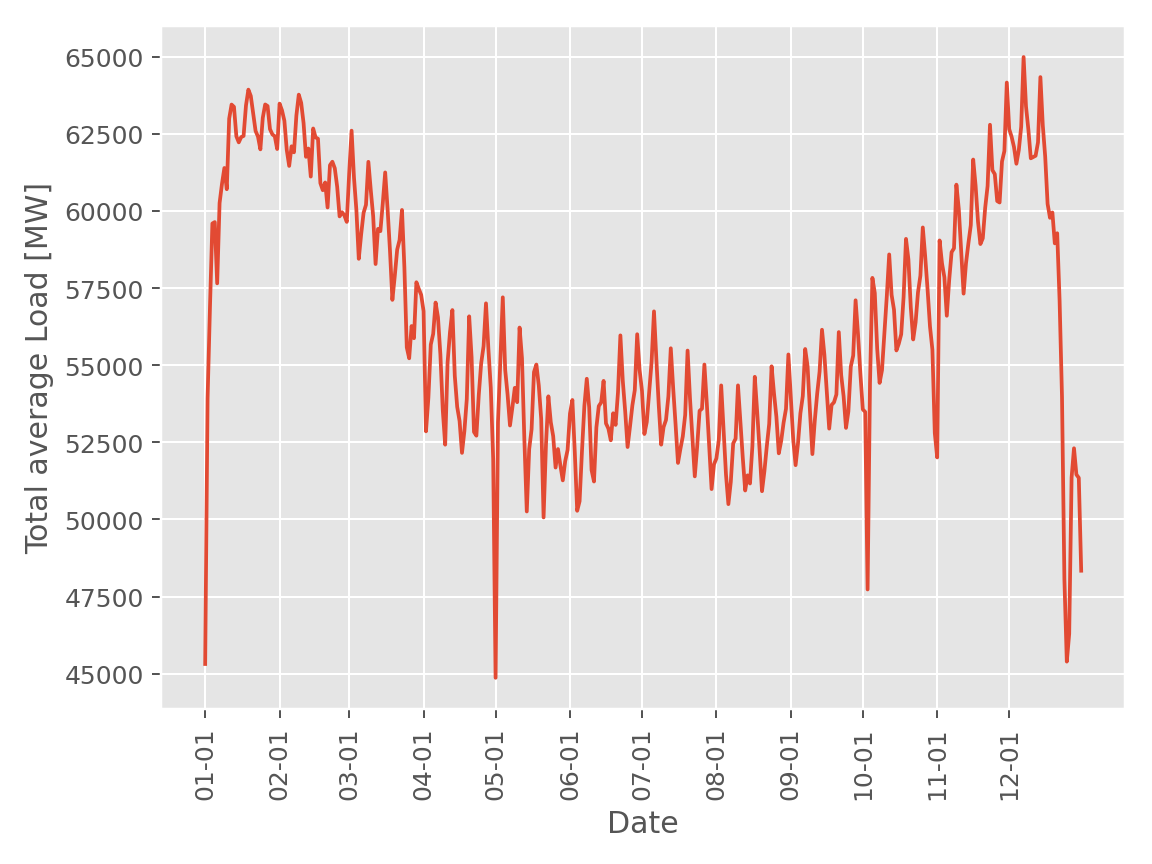

In [32]:
fig, axs = plt.subplots(3,1)
for i, time_scale in enumerate(['month', 'hour', 'day']):
    ax = axs[i]
    ax.plot(df.groupby(time_scale)['Load'].mean(), label=key)
    ax.set_xlabel(time_scale)
    ax.set_ylabel('Load [MW]')
    
axs[0].set_title('Total average load')
plt.tight_layout()
plt.savefig('temporal_variation_load.png')

df_t = df.groupby('date')['Load'].mean()
x, y = df_t.index, df_t.values

plt.figure()
plt.plot(x, y)
plt.xticks([string for string in list(x) if string.split('-')[-1]=='01'], rotation=90)
plt.xlabel('Date')
plt.ylabel('Total average Load [MW]')
plt.tight_layout()
plt.savefig('temporal_variation_load_2.png')



INSIGHTS:
- Load peaks in winter and during the day
- Load drops during weekend (Day 5 and 6 is Saturday and Sunday)
- Load drops at specific days: 05-01 (Labor day), 10-03 (Day of German Unity), 12-24 - 12-26 (Christmas), 12-31 and 01-01 (new year), 11-01 (All saints day)

<IPython.core.display.Javascript object>


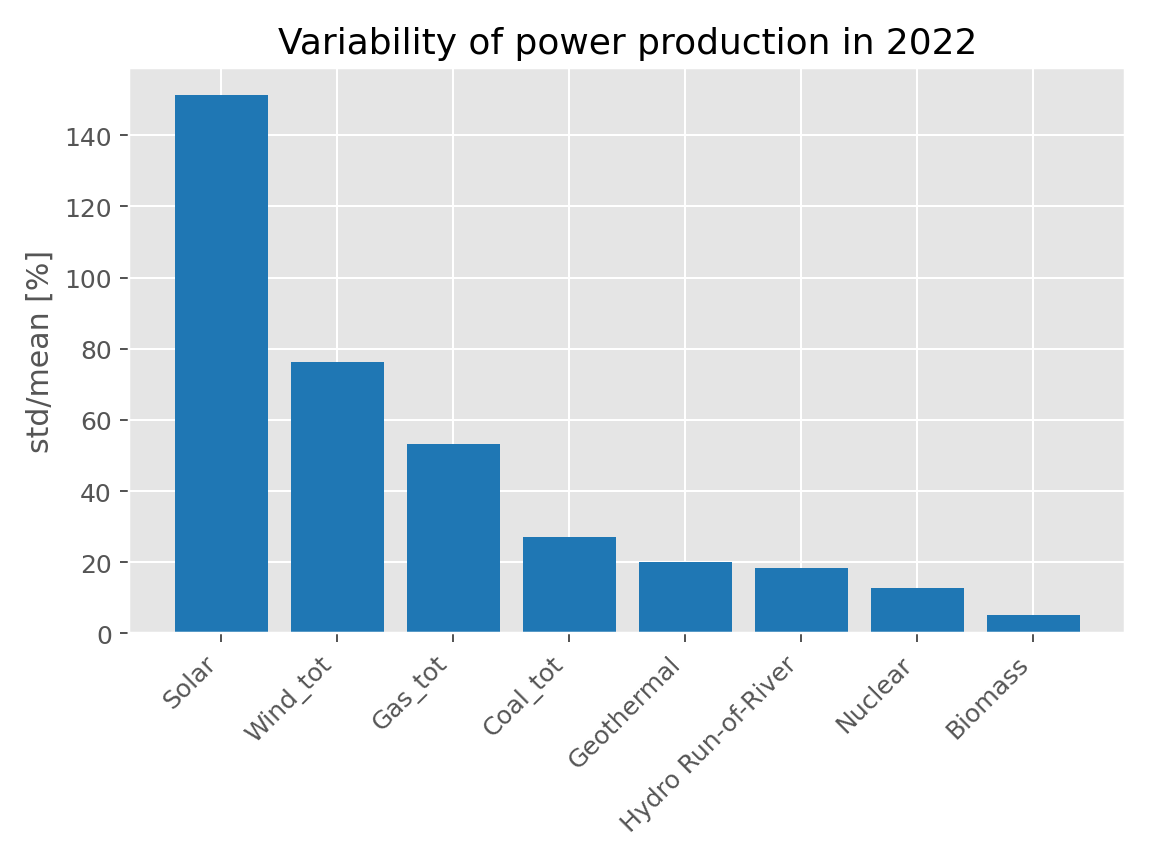

In [33]:
def get_variability(x):
    return 100*np.std(x)/np.mean(x)

keys = ['Solar', 'Wind_tot', 'Biomass', 'Hydro Run-of-River', 'Geothermal', 'Nuclear', 'Gas_tot', 'Coal_tot']

year = 2022
df_t = df[df['year']==year][keys].apply(get_variability).sort_values(ascending=False)

plt.figure()
plt.bar(df_t.index, df_t.values, color='tab:blue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('std/mean [%]')
plt.title(f'Variability of power production in {year}')
plt.tight_layout()
plt.savefig('variability_vs_power_type.png')


# Explore weater data

In [11]:
keys_wind = [key for key in df.keys() if 'wind_speed' in key]
keys_radiation = [key for key in df.keys() if 'radiation_global' in key]
keys_sunshine = [key for key in df.keys() if 'sunshine_duration' in key]

<IPython.core.display.Javascript object>


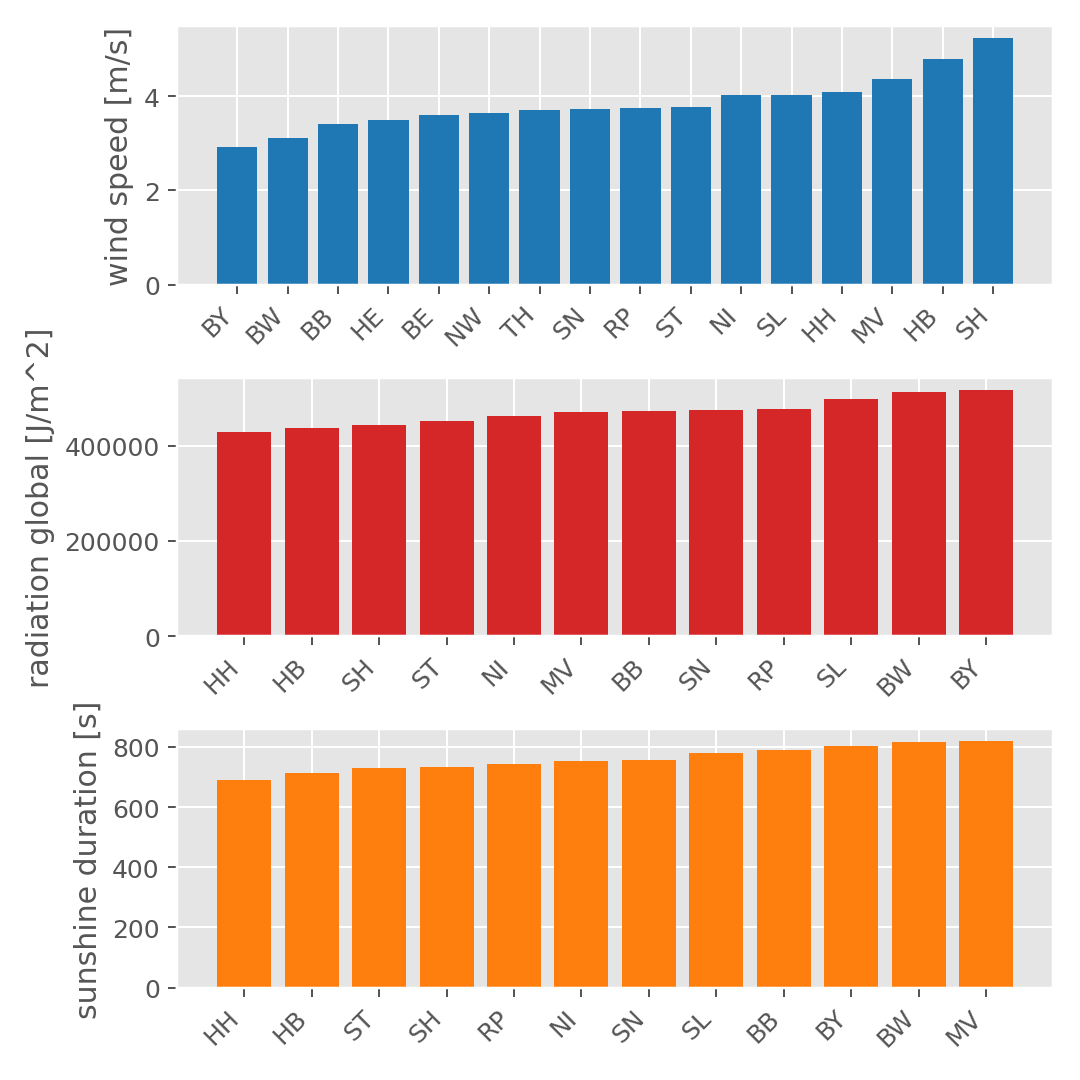

/var/folders/m1/s_4m97wj39bdb0744dj4wxyh0000gn/T/ipykernel_36389/3037622148.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=45, ha='right')
/var/folders/m1/s_4m97wj39bdb0744dj4wxyh0000gn/T/ipykernel_36389/3037622148.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=45, ha='right')
/var/folders/m1/s_4m97wj39bdb0744dj4wxyh0000gn/T/ipykernel_36389/3037622148.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=45, ha='right')


In [12]:
colors=['tab:blue', 'tab:red', 'tab:orange']
units = ['m/s', 'J/m^2', 's']
fig, axs = plt.subplots(3,1, figsize=(6,6))
for i, key in enumerate([keys_wind, keys_radiation, keys_sunshine]):
    df_t = df[key].mean().sort_values()
    x = [string.split('_')[-1] for string in df_t.index]
    y = df_t.values
    
    ax = axs[i]
    ylabel= key[0].split('_')[0]+' '+key[0].split('_')[1]
    ax.bar(x, y, color=colors[i])
    ax.set_ylabel(f'{ylabel} [{units[i]}]')
    ax.set_xticklabels(x, rotation=45, ha='right')
   
plt.tight_layout()

# Explore correlations

<IPython.core.display.Javascript object>


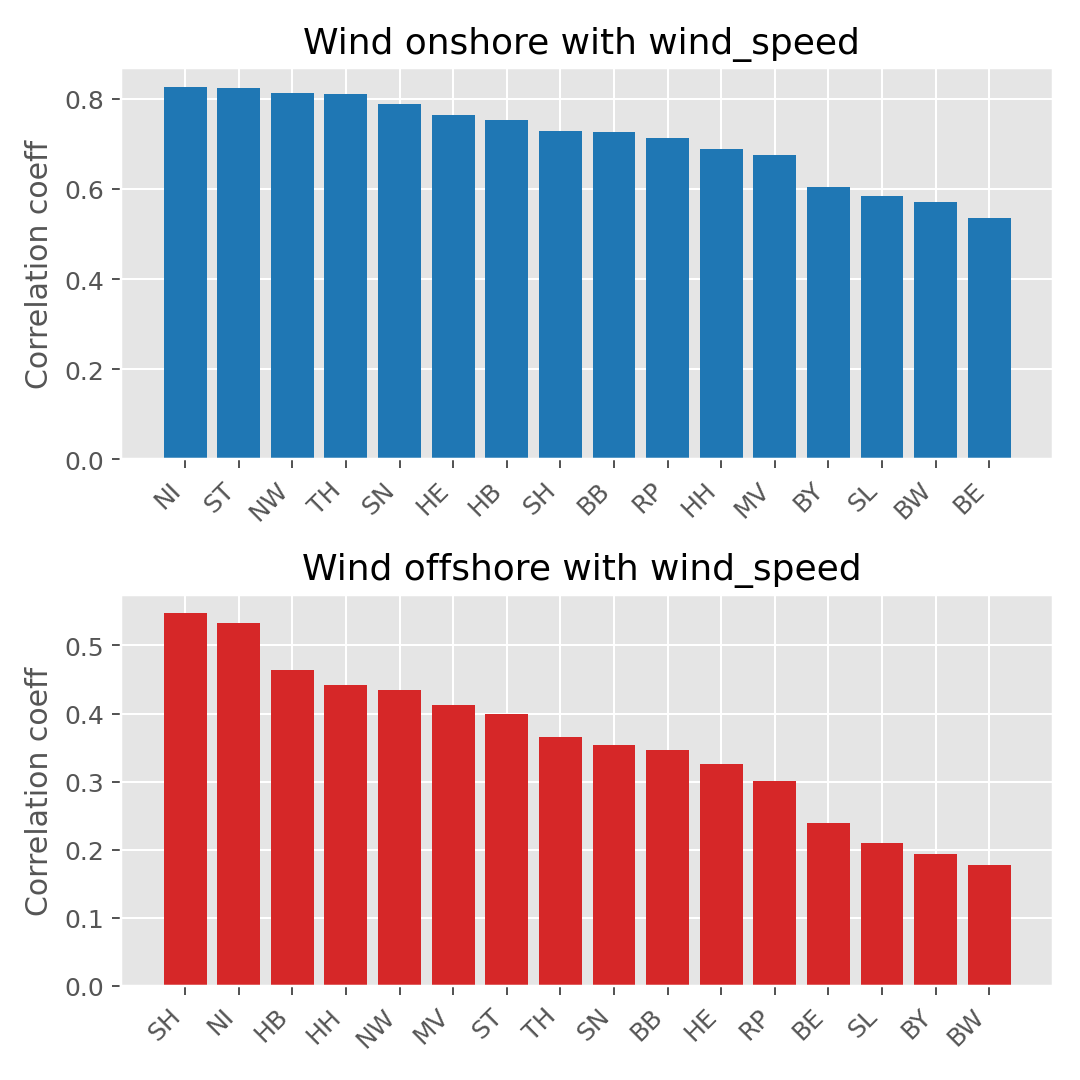

/var/folders/m1/s_4m97wj39bdb0744dj4wxyh0000gn/T/ipykernel_36389/519691134.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=45, ha='right')
/var/folders/m1/s_4m97wj39bdb0744dj4wxyh0000gn/T/ipykernel_36389/519691134.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=45, ha='right')


In [13]:
fig, axs = plt.subplots(2,1, figsize=(6,6))
for i, target in enumerate(['Wind onshore', 'Wind offshore']):
    features = keys_wind
    ax = axs[i]
    cm = df[[target]+features].corr()[target].iloc[1:].sort_values(ascending=False)
    x = [key.split('_')[-1] for key in cm.index]
    y = cm.values
    ax.bar(x, y, color=['tab:blue', 'tab:red'][i])
    ax.set_xticklabels(x, rotation=45, ha='right')
    ax.set_ylabel('Correlation coeff')
    
    ax.set_title(f'{target} with wind_speed ')
plt.tight_layout()

<IPython.core.display.Javascript object>


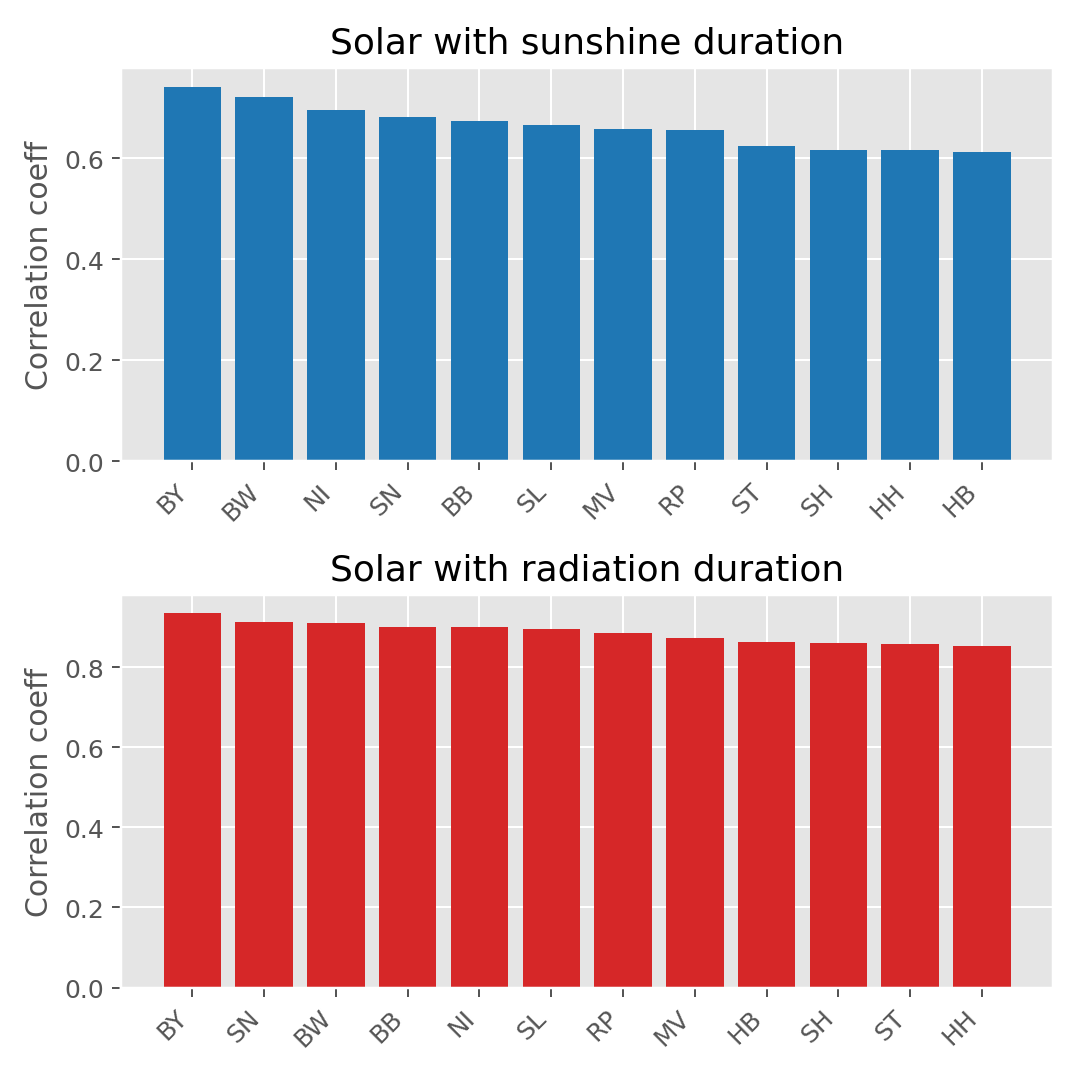

/var/folders/m1/s_4m97wj39bdb0744dj4wxyh0000gn/T/ipykernel_36389/2883250959.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=45, ha='right')
/var/folders/m1/s_4m97wj39bdb0744dj4wxyh0000gn/T/ipykernel_36389/2883250959.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=45, ha='right')


In [14]:
fig, axs = plt.subplots(2,1, figsize=(6,6))
for i, features in enumerate([keys_sunshine, keys_radiation]):
    f = features[0].split('_')[0]+' '+keys_sunshine[0].split('_')[1]
    target = 'Solar'
    ax = axs[i]
    cm = df[[target]+features].corr()[target].iloc[1:].sort_values(ascending=False)
    x = [key.split('_')[-1] for key in cm.index]
    y = cm.values
    ax.bar(x, y, color=['tab:blue', 'tab:red'][i])
    ax.set_xticklabels(x, rotation=45, ha='right')
    ax.set_ylabel('Correlation coeff')
    ax.set_title(f'Solar with {f}')
    
plt.tight_layout()

INSIGHTS: 
- onshore wind power generation is highly correlated with wind speeds
- offshore wind power generation is features smaller correlation with wind speed. It would be beneficial to have data from an offshore weather station!
- Solar generation is highly correlated with both sunshine duration and gloabl radiation level

<IPython.core.display.Javascript object>


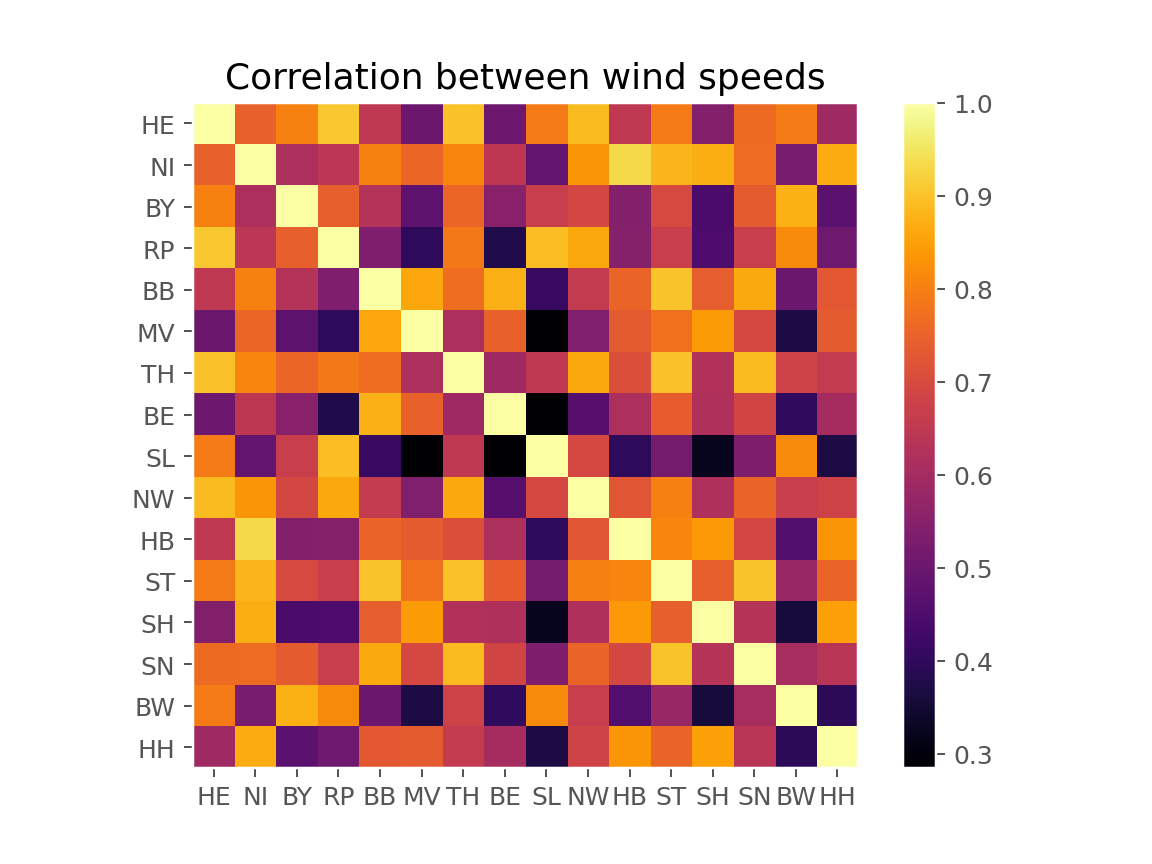

<IPython.core.display.Javascript object>


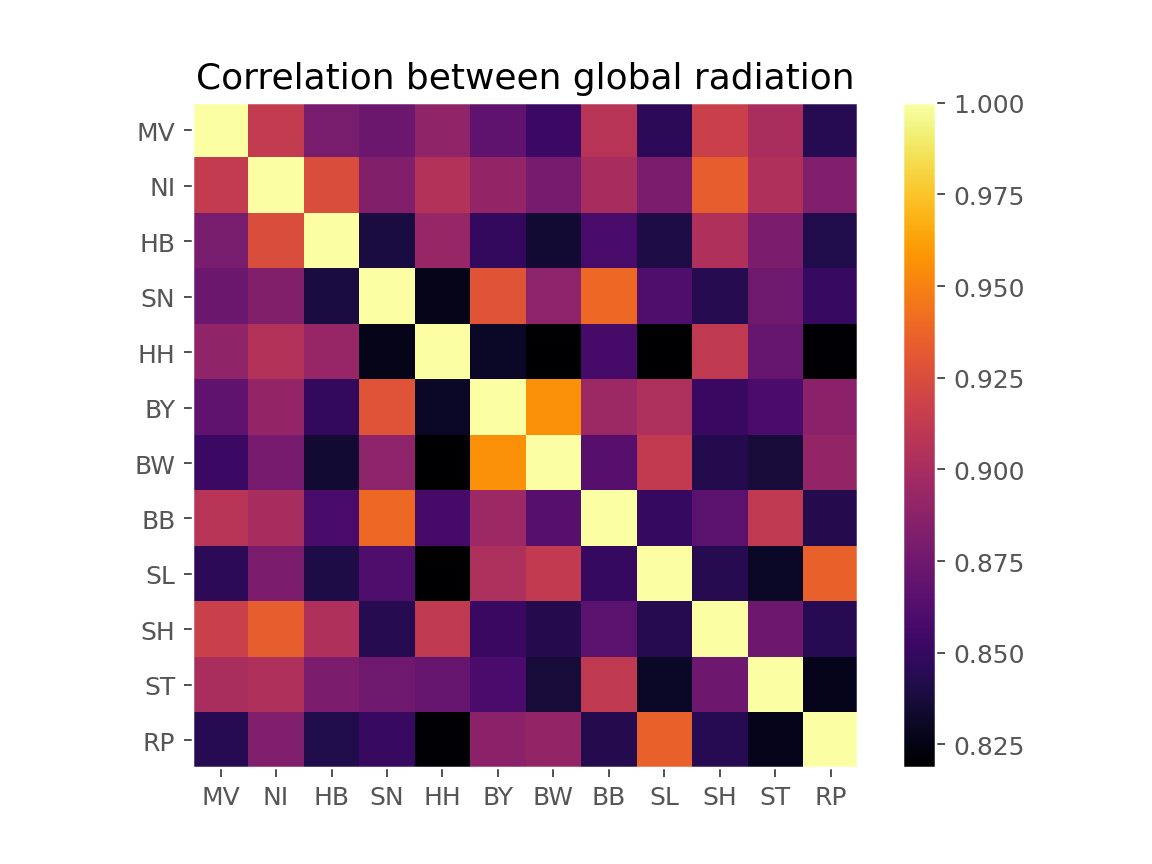

Text(0.5, 1.0, 'Correlation between global radiation')

In [15]:
keys = keys_wind
cm = df[keys].corr()
labels = [string.split('_')[-1] for string in keys]
plt.figure()
plt.imshow(cm, cmap='inferno')
plt.colorbar()
plt.xticks(np.arange(len(labels)), labels)
plt.yticks(np.arange(len(labels)), labels)
plt.grid(False)
plt.title('Correlation between wind speeds')

keys = keys_radiation
cm = df[keys].corr()
labels = [string.split('_')[-1] for string in keys]
plt.figure()
plt.imshow(cm, cmap='inferno')
plt.colorbar()
plt.xticks(np.arange(len(labels)), labels)
plt.yticks(np.arange(len(labels)), labels)
plt.grid(False)
plt.title('Correlation between global radiation')


INSIGHTS: 
- Wind speeds in different states feature large correlations due to geographical proximity, (i.e. HB: Bremen and NI: Niedersachsen)
- Global radiation is much less correlated, i.e. geographical variability is larger

# Baseline model that predicts wind_generation

Train on data from 2015-2022 and test on data from 2023

features are 
- wind_speeds in the different states
- year, to capture the rise of installed wind power
- month, to capture yearly variability of wind 
- hour, to capture daily variability of wind


As a baseline, we simply use a linear regression

In [16]:
df_train = df[df['year']<2023]
df_test = df[df['year']>=2023]

features = []
features.extend(keys_wind)
#features.extend(keys_radiation)
#features.extend(keys_sunshine)

features.extend(['year', 'month', 'hour'])
target = 'Wind_tot'

model = LinearRegression()
model.fit(df_train[features], df_train[target])

df_test[target+'_pred'] = model.predict(df_test[features])
df_train[target+'_pred'] = model.predict(df_train[features])

/var/folders/m1/s_4m97wj39bdb0744dj4wxyh0000gn/T/ipykernel_36389/643322093.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[target+'_pred'] = model.predict(df_test[features])
/var/folders/m1/s_4m97wj39bdb0744dj4wxyh0000gn/T/ipykernel_36389/643322093.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[target+'_pred'] = model.predict(df_train[features])


## Evaluate hourly prediction

<IPython.core.display.Javascript object>


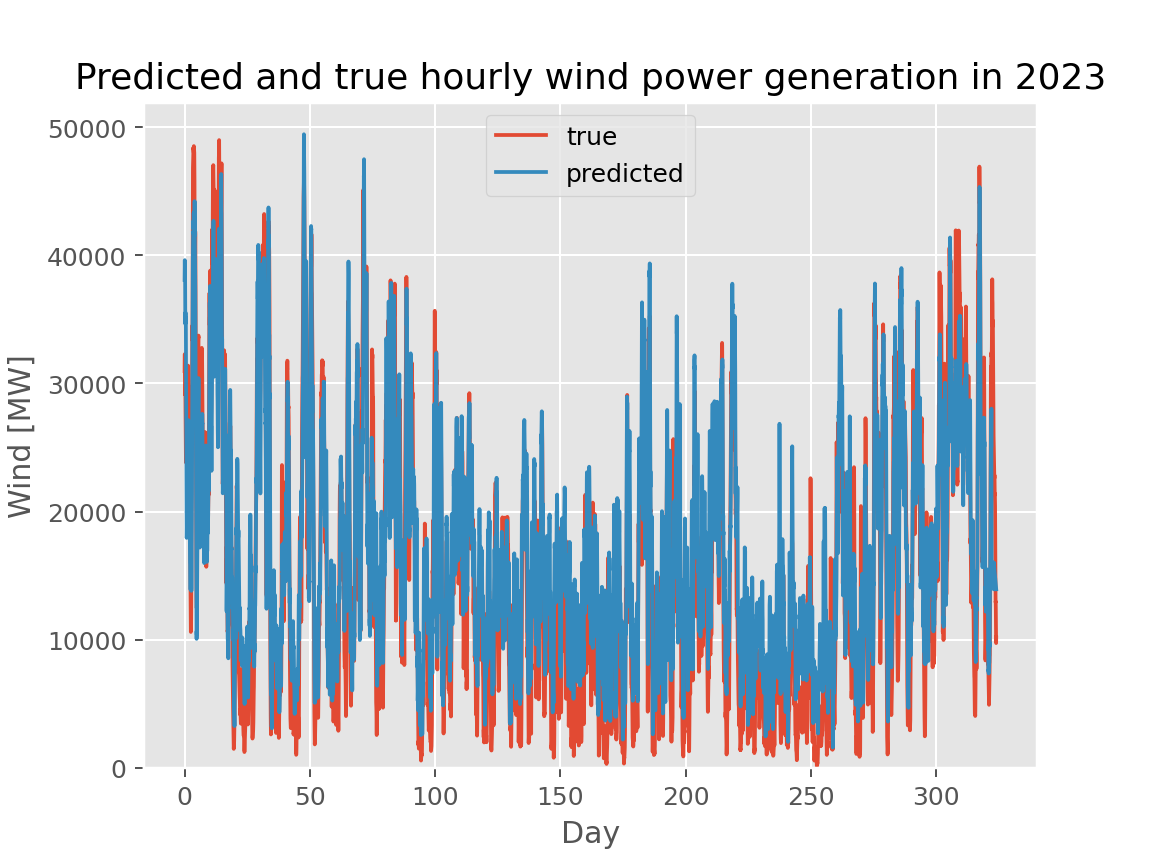

Test data: 
Mean squared error (norm.) = 0.1198
Mean absolute error (norm.) = 0.2855
R squared value = 0.6289

Training data:
Mean squared error (norm.) = 0.105
Mean absolute error (norm.) = 0.2549
R squared value = 0.787


In [34]:
y_true = df_test[target].values
y_pred = df_test[target+'_pred']
x = np.arange(len(y_true))/24

plt.figure()
plt.plot(x, y_true, label='true')
plt.plot(x, y_pred, label='predicted')

plt.title('Predicted and true hourly wind power generation in 2023')
plt.legend()
plt.xlabel('Day')
plt.ylabel(target.split('_')[0]+' [MW]')
plt.ylim([0, None])


# Compute metrics
mse = metrics.mean_squared_error(df_test[target+'_pred'].values, df_test[target].values)/(np.mean(df_test[target])**2)
mae = metrics.mean_absolute_error(df_test[target+'_pred'].values, df_test[target].values)/(np.mean(df_test[target]))
r2 = metrics.r2_score(df_test[target+'_pred'].values, df_test[target].values)

print('Test data: ')
print('Mean squared error (norm.) =', round(mse, 4))
print('Mean absolute error (norm.) =', round(mae, 4))
print('R squared value =', round(r2, 4))
print()

# Compute metrics, training data
mse = metrics.mean_squared_error(df_train[target+'_pred'].values, df_train[target].values)/(np.mean(df_train[target])**2)
mae = metrics.mean_absolute_error(df_train[target+'_pred'].values, df_train[target].values)/(np.mean(df_train[target]))
r2 = metrics.r2_score(df_train[target+'_pred'].values, df_train[target].values)
print('Training data:')
print('Mean squared error (norm.) =', round(mse, 4))
print('Mean absolute error (norm.) =', round(mae, 4))
print('R squared value =', round(r2, 4))

plt.savefig('hourly_predictions_wind.png')



## Evaluate daily prediction

<IPython.core.display.Javascript object>


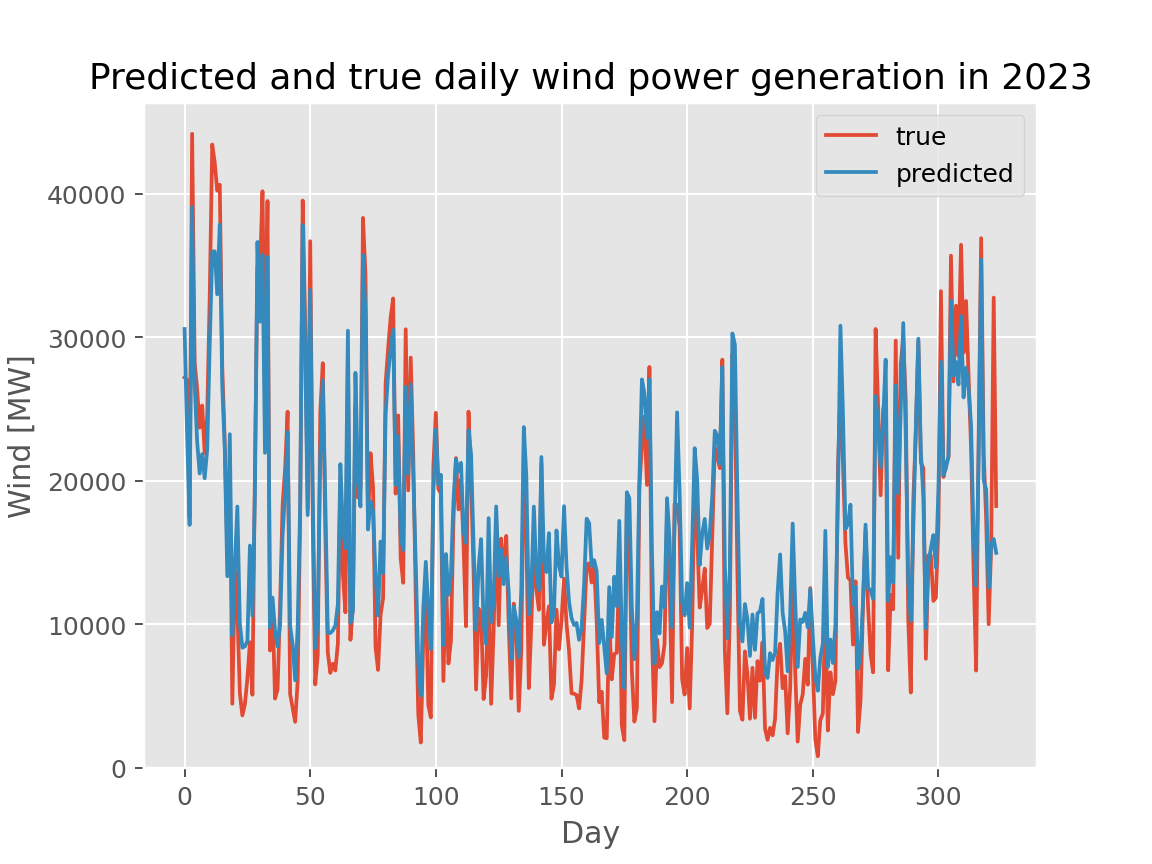

Test data:
Mean squared error (norm.) = 0.0603
Mean absolute error (norm.) = 0.2098
R squared value = 0.7615
Training data:
Mean squared error (norm.) = 0.0095
Mean absolute error (norm.) = 0.0809
R squared value = 0.9031


In [35]:
df_t = df_test.groupby('date')[[target, target+'_pred']].mean()
df_tr = df_train.groupby('date')[[target, target+'_pred']].mean()

y_true = df_t[target].values
y_pred = df_t[target+'_pred']
x = np.arange(len(y_true))

plt.figure()
plt.plot(x, y_true, label='true')
plt.plot(x, y_pred, label='predicted')

plt.title('Predicted and true daily wind power generation in 2023')
plt.legend()
plt.xlabel('Day')
plt.ylabel(target.split('_')[0]+' [MW]')
plt.ylim([0, None])


# Compute metrics
mse = metrics.mean_squared_error(df_t[target+'_pred'].values, df_t[target].values)/(np.mean(df_t[target])**2)
mae = metrics.mean_absolute_error(df_t[target+'_pred'].values, df_t[target].values)/(np.mean(df_t[target]))
r2 = metrics.r2_score(df_t[target+'_pred'].values, df_t[target].values)

print('Test data:')
print('Mean squared error (norm.) =', round(mse, 4))
print('Mean absolute error (norm.) =', round(mae, 4))
print('R squared value =', round(r2, 4))

# Compute metrics, training data
mse = metrics.mean_squared_error(df_tr[target+'_pred'].values, df_tr[target].values)/(np.mean(df_tr[target])**2)
mae = metrics.mean_absolute_error(df_tr[target+'_pred'].values, df_tr[target].values)/(np.mean(df_tr[target]))
r2 = metrics.r2_score(df_tr[target+'_pred'].values, df_tr[target].values)
print('Training data:')
print('Mean squared error (norm.) =', round(mse, 4))
print('Mean absolute error (norm.) =', round(mae, 4))
print('R squared value =', round(r2, 4))

plt.savefig('daily_predictions_wind.png')


## Check feature importance

<IPython.core.display.Javascript object>


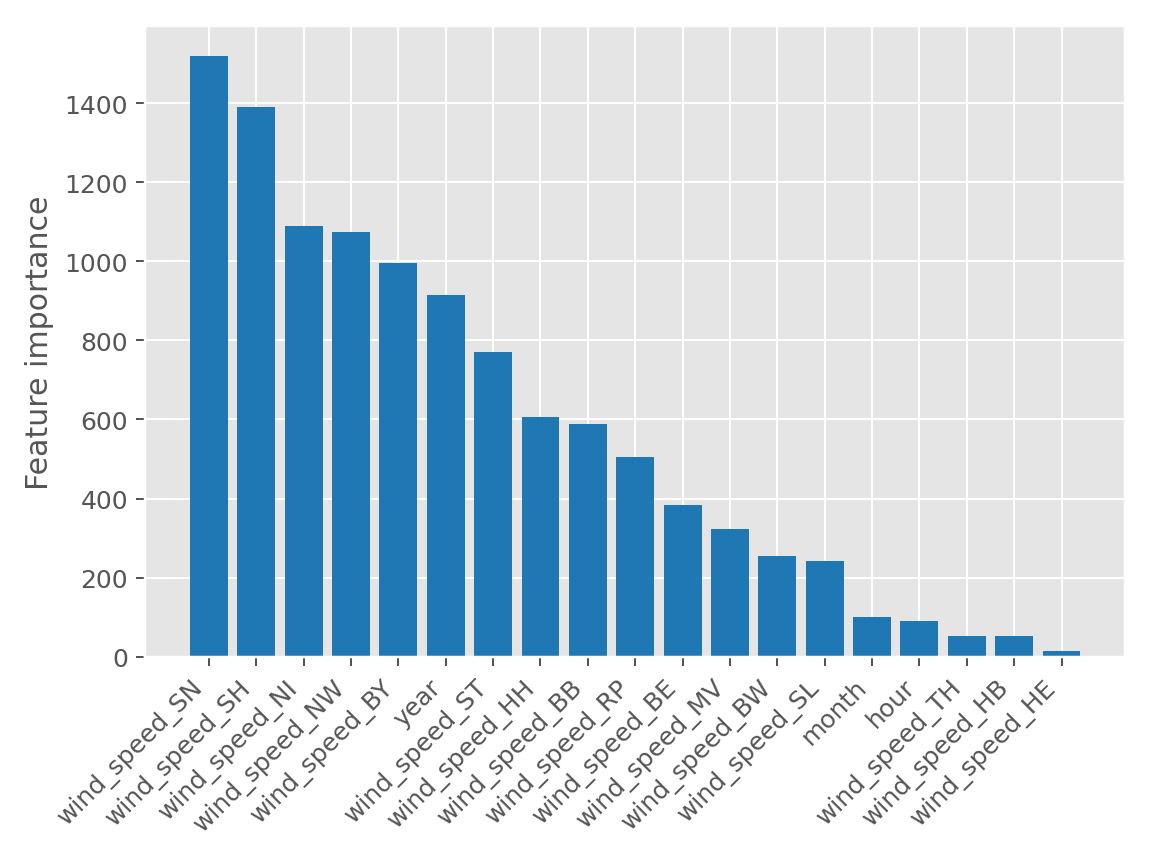

In [21]:
df_t = pd.DataFrame({'labels':features, 'feature_importance':abs(model.coef_)})
df_t = df_t.sort_values('feature_importance', ascending=False)

plt.figure()
plt.bar(df_t['labels'], df_t['feature_importance'], color='tab:blue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Feature importance')
plt.tight_layout()

INSIGHTS:
- The wind speed in some states does not seem to matter at all, this might be either due to correlations between the wind speeds or due to the fact that some states have less installed wind power
- Month and hour have very little importance
- Wind speeds in SN and SH (Sachsen and Schleswig Holstein) are most important, likely due to large (off shore) installed wind power